In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from IPython.display import display, Markdown
import streamlit as st
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pickle

In [2]:
# Load the dataset from the uploaded file
file_path = 'all_reports.xlsx'
data = pd.read_excel(file_path, sheet_name=None)  # Loading all sheets to inspect

# Display the sheet names and preview the first few rows of each sheet
data_sheets_preview = {sheet_name: data[sheet_name].head() for sheet_name in data.keys()}
data_sheets_preview


{'Reports':    Patient Name        Date  Systolic Pressure  Diastolic Pressure  \
 0  NGINA WAMBUI  2024-10-18                 12               130.0   
 1  ROSE WANJIRU  2024-10-17                 30                40.0   
 2  ROSE WANJIRU  2024-10-08                100                60.0   
 3    ABDI MALIK  2024-10-29                100                60.0   
 4    ABDI MALIK  2024-09-26                100               160.0   
 
    Pulse Rate  Temperature  SPO2  
 0          32         36.0    95  
 1          12         37.0    69  
 2          45         38.0    98  
 3          35         37.0    98  
 4          67         39.0    95  }

In [3]:
# Define thresholds for each health metric to determine patient condition
def determine_condition(row):
    # Setting conditions based on provided health thresholds
    if (
        90 <= row['Systolic Pressure'] <= 120 and
        60 <= row['Diastolic Pressure'] <= 80 and
        60 <= row['Pulse Rate'] <= 100 and
        36.5 <= row['Temperature'] <= 37.5 and
        95 <= row['SPO2'] <= 100
    ):
        return "Normal"
    else:
        return "At Risk"

# Apply the function to create a new 'Condition' column in the dataset
data['Reports']['Condition'] = data['Reports'].apply(determine_condition, axis=1)

# Check the dataset with the new 'Condition' column added
data['Reports'].head()


,Patient Name,Date,Systolic Pressure,Diastolic Pressure,Pulse Rate,Temperature,SPO2,Condition
0,NGINA WAMBUI,2024-10-18,12,130.0,32,36.0,95,At Risk
1,ROSE WANJIRU,2024-10-17,30,40.0,12,37.0,69,At Risk
2,ROSE WANJIRU,2024-10-08,100,60.0,45,38.0,98,At Risk
3,ABDI MALIK,2024-10-29,100,60.0,35,37.0,98,At Risk
4,ABDI MALIK,2024-09-26,100,160.0,67,39.0,95,At Risk


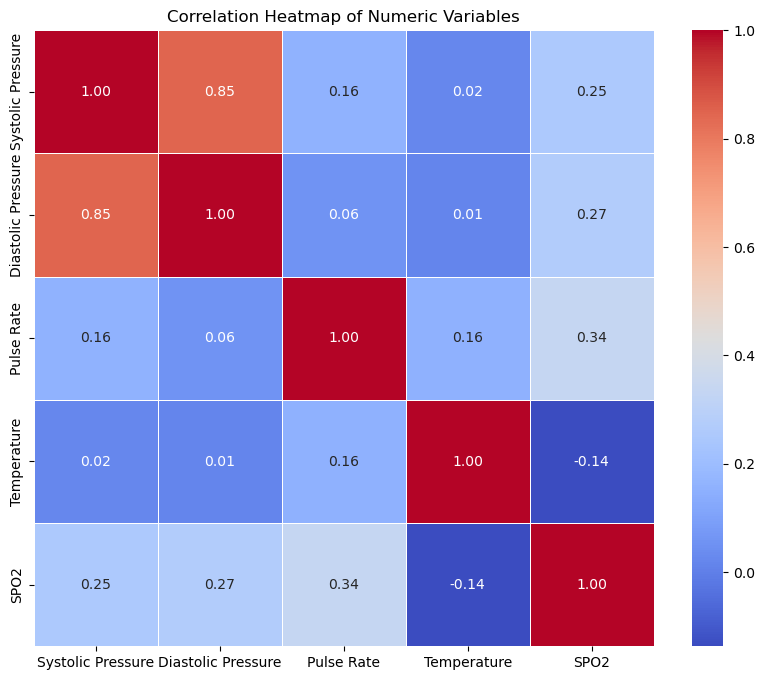

In [4]:
# Select only the numeric columns for correlation analysis
numeric_data = data['Reports'].select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns only
correlation_matrix_numeric = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

In [5]:
# Encode the target variable 'Condition'
label_encoder = LabelEncoder()
data['Reports']['Condition'] = label_encoder.fit_transform(data['Reports']['Condition'])

In [6]:
# Selecting features and target
X = data['Reports'][['Systolic Pressure', 'Diastolic Pressure', 'Pulse Rate', 'Temperature', 'SPO2']]
y = data['Reports']['Condition']

In [7]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SVM Model Accuracy: 0.9375
Confusion Matrix for SVM:
 [[15  0]
 [ 1  0]]
Random Forest Model Accuracy: 0.9375
Confusion Matrix for Random Forest:
 [[15  0]
 [ 1  0]]
XGBoost Model Accuracy: 0.9375
Confusion Matrix for XGBoost:
 [[15  0]
 [ 1  0]]
Decision Tree Model Accuracy: 0.875
Confusion Matrix for Decision Tree:
 [[14  1]
 [ 1  0]]


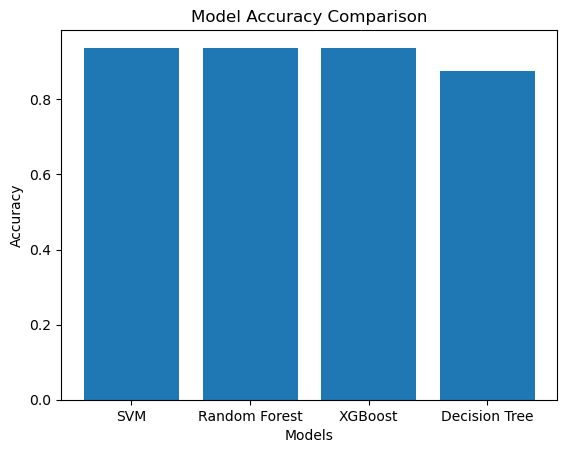

Best model 'SVM' saved as best_model.pkl


In [8]:
# Initialize models
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),  # XGBoost requires eval_metric
    "Decision Tree": DecisionTreeClassifier()
}

# Train and evaluate models
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Model Accuracy: {acc}")
    print(f"Confusion Matrix for {name}:\n", confusion_matrix(y_test, y_pred))

# Step 3: Plot the Model Accuracies
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

# Step 4: Select the Best Model and Save it as .pkl
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print(f"Best model '{best_model_name}' saved as best_model.pkl")


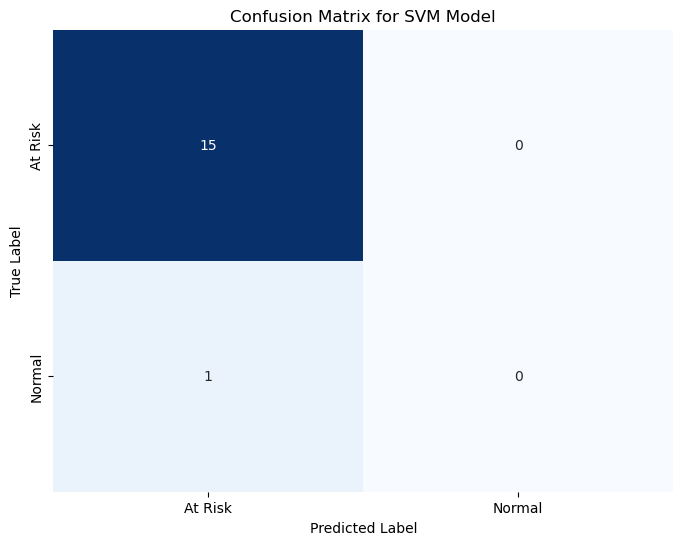

In [9]:
best_model = models["SVM"]

# Predict on the test set
y_pred_svm = best_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["At Risk", "Normal"], yticklabels=["At Risk", "Normal"])  # Adjust labels as needed
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SVM Model")
plt.show()

In [10]:
# Assuming X includes all rows in data['Reports']
y_pred_svm_full = models["SVM"].predict(X)  # Predict on the entire dataset

# Add the predictions to the dataset
data['Reports']['SVM_Prediction'] = y_pred_svm_full

# Save the updated dataset with SVM predictions as a .pkl file
with open("modeled_dataset_svm.pkl", "wb") as file:
    pickle.dump(data['Reports'], file)

print("Modeled dataset with SVM predictions saved as 'modeled_dataset_svm.pkl'")


Modeled dataset with SVM predictions saved as 'modeled_dataset_svm.pkl'


In [11]:
import streamlit as st
import pickle
import pandas as pd

# Load the SVM model
with open("modeled_dataset_svm.pkl", "rb") as f:
    model = pickle.load(f)

# Streamlit app title and description
st.title("Predicting Condition App")
st.write("This app predicts the patient's condition based on health metrics.")

# User input form for health metrics
st.write("Please input the following health values for prediction:")

# Input fields based on health metrics
systolic_pressure = st.number_input("Systolic Pressure (mmHg)", min_value=50, max_value=200, value=110)
diastolic_pressure = st.number_input("Diastolic Pressure (mmHg)", min_value=30, max_value=120, value=75)
pulse_rate = st.number_input("Pulse Rate (bpm)", min_value=40, max_value=150, value=70)
temperature = st.number_input("Temperature (°C)", min_value=30.0, max_value=42.0, value=37.0)
spo2 = st.number_input("SPO2 (%)", min_value=80, max_value=100, value=98)

# Define thresholds to determine patient condition
def determine_condition(row):
    if (
        90 <= row['Systolic Pressure'] <= 120 and
        60 <= row['Diastolic Pressure'] <= 80 and
        60 <= row['Pulse Rate'] <= 100 and
        36.5 <= row['Temperature'] <= 37.5 and
        95 <= row['SPO2'] <= 100
    ):
        return "Normal"
    else:
        return "At Risk"

# Prediction function
if st.button("Predict"):
    # Convert input data into a DataFrame for model prediction
    input_data = pd.DataFrame(
        [[systolic_pressure, diastolic_pressure, pulse_rate, temperature, spo2]],
        columns=["Systolic Pressure", "Diastolic Pressure", "Pulse Rate", "Temperature", "SPO2"]
    )
    
    # Use the SVM model to predict
    prediction = model.predict(input_data)[0]
    st.write("Predicted Condition (from SVM model):", prediction)

    # Determine patient condition based on the provided thresholds
    condition = determine_condition(input_data.iloc[0])
    st.write("Health Status Based on Thresholds:", condition)

    # Optional: Display the dataset sample (uncomment if you want to show it)
    # st.write(data['Reports'].head())


2024-11-05 14:56:38.103 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-05 14:56:38.795 
  command:

    streamlit run c:\Users\user\OneDrive - Strathmore University\Projects\ipykernel_launcher.py [ARGUMENTS]
2024-11-05 14:56:38.796 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-05 14:56:38.796 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-05 14:56:38.797 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-05 14:56:38.799 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-05 14:56:38.801 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-05 14:56:38.802 Thread 'Ma